In [1]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c neurips-open-polymer-prediction-2025
!unzip /content/neurips-open-polymer-prediction-2025.zip
!rm /content/neurips-open-polymer-prediction-2025.zip

Mounted at /content/drive
  0% 0.00/274k [00:00<?, ?B/s]
100% 274k/274k [00:00<00:00, 427MB/s]
Archive:  /content/neurips-open-polymer-prediction-2025.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: train_supplement/dataset1.csv  
  inflating: train_supplement/dataset2.csv  
  inflating: train_supplement/dataset3.csv  
  inflating: train_supplement/dataset4.csv  


In [2]:
%%capture
# !pip install autogluon.tabular[all]
!pip install optuna
!pip install rdkit
!pip install torch-molecule

## Import Packages

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models

from sklearn.feature_selection import f_classif

# from autogluon.tabular import TabularDataset, TabularPredictor

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.Chem import rdmolops
import networkx as nx

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from scipy.stats import uniform, randint

## Load Data

In [4]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
sub = pd.read_csv('/content/sample_submission.csv')

In [5]:
train1 = pd.read_csv('/content/train_supplement/dataset1.csv')
train1 = train1.rename(columns = {'TC_mean': 'Tc'}).head()
# train2 = pd.read_csv('/content/train_supplement/dataset2.csv', index_col = 0)
train3 = pd.read_csv('/content/train_supplement/dataset3.csv')
train4 = pd.read_csv('/content/train_supplement/dataset4.csv')

In [6]:
# Preprocess
def clean_and_validate_smiles(smiles):
    """Completely clean and validate SMILES, removing all problematic patterns"""
    if not isinstance(smiles, str) or len(smiles) == 0:
        return None

    # List of all problematic patterns we've seen
    bad_patterns = [
        '[R]', '[R1]', '[R2]', '[R3]', '[R4]', '[R5]',
        "[R']", '[R"]', 'R1', 'R2', 'R3', 'R4', 'R5',
        # Additional patterns that cause issues
        '([R])', '([R1])', '([R2])',
    ]

    # Check for any bad patterns
    for pattern in bad_patterns:
        if pattern in smiles:
            return None

    # Additional check: if it contains ] followed by [ without valid atoms, likely polymer notation
    if '][' in smiles and any(x in smiles for x in ['[R', 'R]']):
        return None

    # Try to parse with RDKit if available
    RDKIT_AVAILABLE = True
    if RDKIT_AVAILABLE:
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                return Chem.MolToSmiles(mol, canonical=True)
            else:
                return None
        except:
            return None

    # If RDKit not available, return cleaned SMILES
    return smiles

# Clean and validate all SMILES
print("🔄 Cleaning and validating SMILES...")
train['SMILES'] = train['SMILES'].apply(clean_and_validate_smiles)
test['SMILES'] = test['SMILES'].apply(clean_and_validate_smiles)

train1['SMILES'] = train1['SMILES'].apply(clean_and_validate_smiles)
train3['SMILES'] = train3['SMILES'].apply(clean_and_validate_smiles)
train4['SMILES'] = train4['SMILES'].apply(clean_and_validate_smiles)

🔄 Cleaning and validating SMILES...


In [7]:
train = pd.concat([train, train1, train3, train4], axis = 0)
train = train.drop_duplicates(subset = 'SMILES', keep='last')
train = train.reset_index(drop = True)

In [ ]:
train.SMILES.nunique(), train.shape

(8882, (8882, 6))

In [8]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

In [ ]:
train.shape, test.shape, sub.shape, train1.shape, train3.shape,train4.shape,

((8882, 6), (3, 1), (3, 6), (5, 2), (46, 2), (862, 2))

In [ ]:
sub

,id,Tg,FFV,Tc,Density,Rg
0,1109053969,0,0,0,0,0
1,1422188626,0,0,0,0,0
2,2032016830,0,0,0,0,0


## EDA

In [ ]:
train.head()

,SMILES,Tg,FFV,Tc,Density,Rg
87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [ ]:
test.head()

,SMILES
id,
1109053969,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...
1422188626,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...
2032016830,*c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...


### Missing Values Check

In [ ]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))#[0]

In [ ]:
# Initialize a list to store data
data = []

for column in train.columns:
    data_type = str(train[column].dtype)

    # Calculate missing percentages
    train_missing = np.round(100 - train[column].count() / train.shape[0] * 100, 1)

    if column in target:
        test_missing = "NA"
        unique_values_count_test = "NA"
        unseen_percentage = "NA"
    else:
        test_missing = np.round(100 - test[column].count() / test.shape[0] * 100, 1)
        unique_values_count_test = test[column].nunique()

        # Compute unique values in train that are NOT in test
        unique_train_values = set(train[column].dropna().unique())
        unique_test_values = set(test[column].dropna().unique())
        unseen_in_test = len(unique_train_values - unique_test_values)
        unseen_percentage = np.round((unseen_in_test / len(unique_train_values)) * 100, 2) if len(unique_train_values) > 0 else 0
    # else:
    #     test_missing = "NA"
    #     unique_values_count_test = "NA"
        # unseen_percentage = "NA"

    # Calculate discrete nature ratio (unique values / total values)
    discrete_ratio = np.round(train[column].nunique() / train.shape[0], 4)
    unique_values_count = train[column].nunique()

    # Append row to list
    data.append([column, data_type, train_missing, test_missing,
                 discrete_ratio, unique_values_count, unique_values_count_test, unseen_percentage])

# Create a DataFrame
df_summary = pd.DataFrame(data, columns=['Feature', 'Data Type', 'Train Missing %', 'Test Missing %',
                                         'Discrete Ratio (Train)', 'Unique Values Count Train',
                                         'Unique Values Count Test', 'Unique % Unseen in Test'])

# Display the DataFrame
df_summary


,Feature,Data Type,Train Missing %,Test Missing %,Discrete Ratio (Train),Unique Values Count Train,Unique Values Count Test,Unique % Unseen in Test
0,SMILES,object,0.0,0.0,1.0000,8882,3,99.97
1,Tg,float64,93.7,NA,0.0626,556,NA,NA
2,FFV,float64,11.1,NA,0.8844,7855,NA,NA
3,Tc,float64,91.7,NA,0.0561,498,NA,NA
4,Density,float64,93.1,NA,0.0687,610,NA,NA
5,Rg,float64,93.1,NA,0.0688,611,NA,NA


In [ ]:
train1.isna().sum()

,0
TC_mean,0


In [ ]:
train3.isna().sum()

,0
Tg,0


In [ ]:
train4.isna().sum()

,0
FFV,0


In [ ]:
train.describe()

,Tg,FFV,Tc,Density,Rg
count,556.000000,7892.000000,738.000000,610.000000,611.000000
mean,99.765367,0.367007,0.256624,0.986185,16.395963
std,111.162938,0.029067,0.089934,0.146166,4.559086
min,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,16.754893,0.349598,0.186000,0.891256,12.528396
50%,77.913615,0.364004,0.236500,0.949296,15.040386
75%,164.908632,0.380173,0.330875,1.062864,20.392752
max,472.250000,0.777097,0.526000,1.840999,34.487303


### Plots

In [ ]:
regression =  True#train[target].nunique() > 10
target = 'FFV'

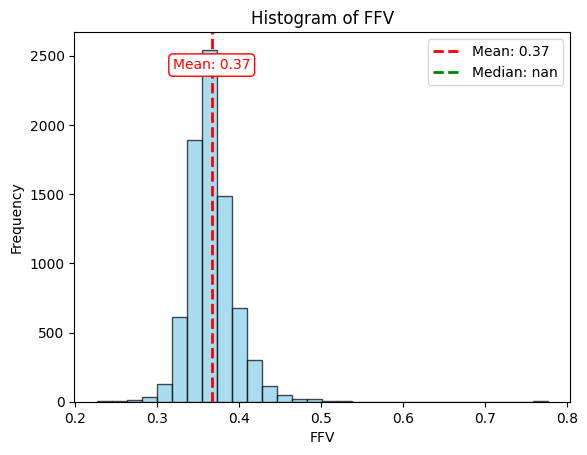

In [ ]:
if regression:
    # Histogram for continuous target
    plt.hist(train[target], bins=30, edgecolor='black', alpha=0.7, color='skyblue')

    # Calculate mean and median
    mean_value = np.mean(train[target])
    median_value = np.median(train[target])

    # Add vertical lines for mean and median
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

    # Add text annotations
    plt.text(mean_value, plt.ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))
    plt.text(median_value, plt.ylim()[1] * 0.8, f'Median: {median_value:.2f}', color='green', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

    # Labels and title
    plt.xlabel(target)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {target}")
    plt.legend()

else:
    # Pie chart for categorical target
    class_counts = train[target].value_counts()
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
    plt.title(f"Distribution of {target}")

plt.show()

In [ ]:
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

#### Numeric

In [ ]:
# Calculate the number of rows needed for the subplots
num_rows = (len(numeric_cols) + 2) // 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each continuous column and plot the histograms
for i, col in enumerate(numeric_cols):
    # Determine the range of values to plot
    max_val = max(train[col].max(), test[col].max())
    min_val = min(train[col].min(), test[col].min())
    range_val = max_val - min_val

    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins = round(range_val / bin_size)

    # Plot the histograms
    axs[i].hist(train[col], bins=num_bins, color='red', alpha=0.5, label='Train', edgecolor='black')
    axs[i].hist(test[col], bins=num_bins, color='grey', alpha=0.5, label='Test', edgecolor='black')

    # Titles and labels
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
if regression:
    # Determine number of rows for subplots (3 columns per row)
  num_rows = (len(numeric_cols) + 2) // 3

  # Create subplots
  fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

  # Flatten the axs array for easy iteration
  axs = axs.flatten()

  # Loop through each numeric column and plot the scatter plot
  for i, col in enumerate(numeric_cols):
      axs[i].scatter(train[col], train[target], alpha=0.5, color='blue', edgecolors='black')
      axs[i].set_title(f"{col} vs {target}")
      axs[i].set_xlabel(col)
      axs[i].set_ylabel(target)

  # Remove any unused subplots
  for j in range(i + 1, len(axs)):
      fig.delaxes(axs[j])

  plt.tight_layout()
  plt.show()

else:
  classes = train[target].unique()

  for col in numeric_cols:
    plt.figure(figsize=(10, 6))

    # Gather data grouped by target
    data_to_plot = [train[train[target] == tgt][col].values for tgt in classes]

    # Create boxplot and get the dictionary of plot elements
    box = plt.boxplot(data_to_plot, labels=classes)

    # Annotate the median values
    for i, median_line in enumerate(box['medians']):
        x, y = median_line.get_xdata(), median_line.get_ydata()
        median_value = y[0]  # both y[0] and y[1] are the same for a horizontal line
        plt.text(x[0], median_value, f'{median_value:.2f}',
                ha='center', va='bottom', fontsize=9, color='blue')

    plt.title(f'Boxplot of {col} by {target}')
    plt.xlabel(target)
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
if regression:
  corr = train[numeric_cols + [target]].corr()
  plt.figure(figsize = (10, 8), dpi = 300)
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = True
  sns.heatmap(corr, mask = mask, cmap = 'coolwarm', annot = True, annot_kws = {'size' : 7}, vmin = -1, vmax = 1)
  plt.title('Features Correlation Matrix\n', fontsize = 15, weight = 'bold')
  plt.show()

else:
  X = train[numeric_cols].fillna(-999)
  y = train[target]

  # Compute ANOVA F-value
  f_vals, p_vals = f_classif(X, y)

  # Create DataFrame
  anova_df = pd.DataFrame({
      'Feature': X.columns.tolist(),
      'F_value': f_vals,
      'p_value': p_vals
  }).sort_values('F_value', ascending=False)

  # Plot
  plt.figure(figsize=(10, 6))
  plt.barh(anova_df['Feature'], anova_df['F_value'], color='skyblue')
  plt.xlabel('ANOVA F-value')
  plt.title('ANOVA Feature Importance for Multiclass Target')
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

#### Categorical

In [ ]:
if regression:
  fig, axs = plt.subplots(len(categorical_cols), 1, figsize=(10, len(categorical_cols) * 4))

  for i, col in enumerate(categorical_cols):
      # Get the top 10 most frequent categories
      top_categories = train[col].value_counts().nlargest(10).index

      # Filter train data to only include top categories
      filtered_train = train[train[col].isin(top_categories)]

      # Create box plot
      axs[i].boxplot(
          [filtered_train[filtered_train[col] == category][target] for category in top_categories],
          labels=top_categories
      )

      axs[i].set_title(f"{col} vs {target}")
      axs[i].set_xlabel(col)
      axs[i].set_ylabel(target)
      axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

  plt.tight_layout()
  plt.show()

else:
  for col in categorical_cols:
    crosstab = pd.crosstab(train[col], train[target], normalize='index')  # row-wise percent
    crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
    plt.title(f'Distribution of {target} by {col}')
    plt.ylabel('Proportion')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
if regression:
  from scipy.stats import kruskal

  kruskal_results = {}

  for col in categorical_cols:
      groups = [train[train[col] == category][target] for category in train[col].unique()]
      if len(groups) > 1:
          stat, p = kruskal(*groups)
          kruskal_results[col] = {"Kruskal-Wallis Statistic": stat, "p-value": p}

  # Convert to DataFrame
  kruskal_df = pd.DataFrame.from_dict(kruskal_results, orient="index")
  display(kruskal_df.sort_values(by="Kruskal-Wallis Statistic", ascending=False))

# Higher statistic → Stronger categorical effect

# Lower p-value → More significant relationship

else:
  chi2_results = {}

  # Encode the multiclass target
  y_encoded = LabelEncoder().fit_transform(train[target])

  for col in categorical_cols:
      # Encode the categorical feature
      x_encoded = LabelEncoder().fit_transform(train[col]).reshape(-1, 1)

      # Run chi-squared test
      stat, p = chi2(x_encoded, y_encoded)
      chi2_results[col] = {"Chi2 Statistic": stat[0], "p-value": p[0]}

  # Convert to DataFrame
  chi2_df = pd.DataFrame.from_dict(chi2_results, orient="index")
  display(chi2_df.sort_values(by="Chi2 Statistic", ascending=False))

### Unique

In [ ]:
train.describe()

,Tg,FFV,Tc,Density,Rg
count,556.000000,7892.000000,738.000000,610.000000,611.000000
mean,99.765367,0.367007,0.256624,0.986185,16.395963
std,111.162938,0.029067,0.089934,0.146166,4.559086
min,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,16.754893,0.349598,0.186000,0.891256,12.528396
50%,77.913615,0.364004,0.236500,0.949296,15.040386
75%,164.908632,0.380173,0.330875,1.062864,20.392752
max,472.250000,0.777097,0.526000,1.840999,34.487303


In [ ]:
train[train['FFV'] >= 0.5]

,SMILES,Tg,FFV,Tc,Density,Rg
177272960,*c1ccc(*)[nH]1,NaN,0.563897,NaN,NaN,NaN
180321996,*CCCCCCCCCC[N+](*)(C)C,NaN,0.769315,NaN,NaN,NaN
370833911,*CCSSSS*,NaN,0.528203,NaN,NaN,NaN
637669265,*CC(*)C(=O)NCCC[N+](C)(C)C,NaN,0.687057,NaN,NaN,NaN
660253930,*c1ccc(-c2sc(-c3ccc(-c4cc(CCCC)c(*)s4)cc3)cc2C...,NaN,0.500778,NaN,NaN,NaN
713393124,*CC(*)C(=O)N1CC[NH+](CC)CC1,NaN,0.650907,NaN,NaN,NaN
750049504,*c1ccc(-c2sc(-c3ccc(-c4cc(SCCCC)c(*)s4)cc3)cc2...,NaN,0.511978,NaN,NaN,NaN
806978622,*CC(*)O[N+](=O)[O-],NaN,0.774066,0.1585,1.305302,17.272314
852184111,*c1cc(C)c(*)s1,NaN,0.516864,NaN,NaN,NaN
1201617221,*c1ccc(-c2sc(-c3cc(SCCCC)c(*)s3)cc2SCCCC)cc1,NaN,0.507618,NaN,NaN,NaN


## Feature Egnineering RDKIT

In [9]:
useless_cols = [
    # Nan data
    'BCUT2D_MWHI',
    'BCUT2D_MWLOW',
    'BCUT2D_CHGHI',
    'BCUT2D_CHGLO',
    'BCUT2D_LOGPHI',
    'BCUT2D_LOGPLOW',
    'BCUT2D_MRHI',
    'BCUT2D_MRLOW',

    # Constant data
    'NumRadicalElectrons',
    'SMR_VSA8',
    'SlogP_VSA9',
    'fr_barbitur',
    'fr_benzodiazepine',
    'fr_dihydropyridine',
    'fr_epoxide',
    'fr_isothiocyan',
    'fr_lactam',
    'fr_nitroso',
    'fr_prisulfonamd',
    'fr_thiocyan',

    # High correlated data >0.95
    'MaxEStateIndex',
    'HeavyAtomMolWt',
    'ExactMolWt',
    'NumValenceElectrons',
    'Chi0',
    'Chi0n',
    'Chi0v',
    'Chi1',
    'Chi1n',
    'Chi1v',
    'Chi2n',
    'Kappa1',
    'LabuteASA',
    'HeavyAtomCount',
    'MolMR',
    'Chi3n',
    'BertzCT',
    'Chi2v',
    'Chi4n',
    'HallKierAlpha',
    'Chi3v',
    'Chi4v',
    'MinAbsPartialCharge',
    'MinPartialCharge',
    'MaxAbsPartialCharge',
    'FpDensityMorgan2',
    'FpDensityMorgan3',
    'Phi',
    'Kappa3',
    'fr_nitrile',
    'SlogP_VSA6',
    'NumAromaticCarbocycles',
    'NumAromaticRings',
    'fr_benzene',
    'VSA_EState6',
    'NOCount',
    'fr_C_O',
    'fr_C_O_noCOO',
    'NumHDonors',
    'fr_amide',
    'fr_Nhpyrrole',
    'fr_phenol',
    'fr_phenol_noOrthoHbond',
    'fr_COO2',
    'fr_halogen',
    'fr_diazo',
    'fr_nitro_arom',
    'fr_phos_ester'
]

desc_names = [desc[0] for desc in Descriptors.descList if desc[0] not in useless_cols]

def compute_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * len(desc_names)
    return [desc[1](mol) for desc in Descriptors.descList if desc[0] not in useless_cols]

def compute_graph_features(smiles, graph_feats):
    mol = Chem.MolFromSmiles(smiles)
    adj = rdmolops.GetAdjacencyMatrix(mol)
    G = nx.from_numpy_array(adj)

    graph_feats['graph_diameter'].append(nx.diameter(G) if nx.is_connected(G) else 0)
    graph_feats['avg_shortest_path'].append(nx.average_shortest_path_length(G) if nx.is_connected(G) else 0)
    graph_feats['num_cycles'].append(len(list(nx.cycle_basis(G))))


def preprocessing(df):
    desc_names = [desc[0] for desc in Descriptors.descList if desc[0] not in useless_cols]
    descriptors = [compute_all_descriptors(smi) for smi in df['SMILES'].to_list()]

    graph_feats = {'graph_diameter': [], 'avg_shortest_path': [], 'num_cycles': []}
    for smile in df['SMILES']:
         compute_graph_features(smile, graph_feats)

    result = pd.concat(
        [
            pd.DataFrame(descriptors, columns=desc_names),
            pd.DataFrame(graph_feats)
        ],
        axis=1
    )

    result = result.replace([-np.inf, np.inf], np.nan)
    return result

In [10]:
train = pd.concat([train, preprocessing(train)], axis=1)
test = pd.concat([test.reset_index(), preprocessing(test)], axis=1).set_index('id')

In [11]:
# A small function to handle potential errors with invalid SMILES strings.
def smiles_to_features(smiles_string, n_bits=1024):
    """
    Takes a SMILES string and returns a dictionary of RDKit molecular
    descriptors and Morgan fingerprints.
    """
    try:
        # Create a molecule object from the SMILES string
        mol = Chem.MolFromSmiles(smiles_string)
        if mol is None:
            return None # Return None for invalid SMILES

        # Calculate a variety of molecular descriptors
        features = {
            # 'MolWt': Descriptors.MolWt(mol),
            # 'ExactMolWt': Descriptors.ExactMolWt(mol),
            # 'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
            # 'NumAromaticRings': Descriptors.NumAromaticRings(mol),
            # 'TPSA': Descriptors.TPSA(mol),
            # 'BalabanJ': Descriptors.BalabanJ(mol),
            # 'NumHDonors': Descriptors.NumHDonors(mol),
            # 'NumHAcceptors': Descriptors.NumHAcceptors(mol),
            # 'HeavyAtomCount': Descriptors.HeavyAtomCount(mol),
            # 'NumHeteroatoms': Descriptors.NumHeteroatoms(mol),
        }

        # Generate Morgan fingerprints using the modern MorganGenerator
        # The MorganGenerator is the recommended way to generate fingerprints.
        # It's more efficient and flexible.
        gen = GetMorganGenerator(radius=2, fpSize=n_bits)
        morgan_fp = gen.GetFingerprint(mol).ToBitString()

        # Add the fingerprint as a new column. We store it as a string to simplify the DataFrame.
        # It can be converted back to an array for modeling later.
        features['MorganFP'] = morgan_fp

        return features

    except Exception as e:
        print(f"Error processing SMILES '{smiles_string}': {e}")
        return None

In [12]:
rdk_feats = pd.DataFrame(train['SMILES'].apply(lambda x : smiles_to_features(x)).to_list(),  index=train.index)

In [13]:
train = pd.concat([train, rdk_feats], axis = 1)

In [14]:
rdk_feats_test = pd.DataFrame(test['SMILES'].apply(lambda x : smiles_to_features(x)).to_list(),  index=test.index)
test = pd.concat([test, rdk_feats_test ], axis = 1)

In [15]:
def expand_and_reduce_morgan_fp(df_train, df_test, fp_col="MorganFP", n_components=50):
    """
    Expands a MorganFP bitstring column into bits,
    then applies PCA to reduce dimensionality.
    Returns updated train and test DataFrames.
    """
    # Convert bitstrings to numpy arrays
    def bitstring_to_array(fp):
        if isinstance(fp, str):
            if set(fp) <= {"0", "1"} and len(fp) > 10:
                return np.array(list(fp), dtype=int)
            else:
                return np.fromstring(fp.strip("[]"), sep=",", dtype=int)
        else:
            return np.array(fp, dtype=int)

    train_bits = np.array([bitstring_to_array(fp) for fp in df_train[fp_col]])
    test_bits = np.array([bitstring_to_array(fp) for fp in df_test[fp_col]])

    # PCA reduction
    pca = PCA(n_components=n_components, random_state=42)
    train_reduced = pca.fit_transform(train_bits)
    test_reduced = pca.transform(test_bits)

    # Create DataFrames for PCA features
    fp_cols = [f"fp_pca_{i}" for i in range(train_reduced.shape[1])]
    train_fp_df = pd.DataFrame(train_reduced, index=df_train.index, columns=fp_cols)
    test_fp_df = pd.DataFrame(test_reduced, index=df_test.index, columns=fp_cols)

    # Drop original FP column and add reduced PCA features
    df_train = pd.concat([df_train.drop(columns=[fp_col]), train_fp_df], axis=1)
    df_test = pd.concat([df_test.drop(columns=[fp_col]), test_fp_df], axis=1)

    return df_train, df_test

# Example usage:
train, test = expand_and_reduce_morgan_fp(train, test, fp_col="MorganFP", n_components=50)

In [16]:
all_features = train.columns[7:].tolist()
targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
features = {}
for target in targets:
    const_descs = []
    for col in train.columns.drop(targets):
        if train[train[target].notnull()][col].nunique() == 1:
            const_descs.append(col)
    features[target] = [f for f in all_features if f not in const_descs]

print(train.shape)
train['Ipc']=np.log10(train['Ipc'])
for n in train.columns[7:]:
    train[n]=train[n].replace(-np.inf,np.nan)
    train[n]=train[n].replace(np.inf,np.nan)
    train[n].fillna(train[n].mean())

print(train.shape)
test['Ipc']=np.log10(test['Ipc'])
for n in test.columns[1:]:
    train[n]=train[n].replace(-np.inf,np.nan)
    train[n]=train[n].replace(np.inf,np.nan)
    test[n].fillna(train[n].mean())

(8882, 208)
(8882, 208)


## Tree Models

#### HGBG

In [17]:
cols_to_fit = [
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'MaxPartialCharge',
 'FpDensityMorgan1',
 'AvgIpc',
 'BalabanJ',
 'Ipc',
 'Kappa2',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA5',
 'SlogP_VSA7',
 'SlogP_VSA8',
 'TPSA',
 'EState_VSA1',
 'EState_VSA10',
 'EState_VSA11',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'EState_VSA5',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'EState_VSA9',
 'VSA_EState1',
 'VSA_EState10',
 'VSA_EState2',
 'VSA_EState3',
 'VSA_EState4',
 'VSA_EState5',
 'VSA_EState7',
 'VSA_EState8',
 'VSA_EState9',
 'FractionCSP3',
 'NHOHCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAmideBonds',
 'NumAromaticHeterocycles',
 'NumAtomStereoCenters',
 'NumBridgeheadAtoms',
 'NumHAcceptors',
 'NumHeteroatoms',
 'NumHeterocycles',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 'NumSpiroAtoms',
 'NumUnspecifiedAtomStereoCenters',
 'RingCount',
 'MolLogP',
 'fr_Al_COO',
 'fr_Al_OH',
 'fr_Al_OH_noTert',
 'fr_ArN',
 'fr_Ar_COO',
 'fr_Ar_N',
 'fr_Ar_NH',
 'fr_Ar_OH',
 'fr_COO',
 'fr_C_S',
 'fr_HOCCN',
 'fr_Imine',
 'fr_NH0',
 'fr_NH1',
 'fr_NH2',
 'fr_N_O',
 'fr_Ndealkylation1',
 'fr_Ndealkylation2',
 'fr_SH',
 'fr_aldehyde',
 'fr_alkyl_carbamate',
 'fr_alkyl_halide',
 'fr_allylic_oxid',
 'fr_amidine',
 'fr_aniline',
 'fr_aryl_methyl',
 'fr_azide',
 'fr_azo',
 'fr_bicyclic',
 'fr_ester',
 'fr_ether',
 'fr_furan',
 'fr_guanido',
 'fr_hdrzine',
 'fr_hdrzone',
 'fr_imidazole',
 'fr_imide',
 'fr_isocyan',
 'fr_ketone',
 'fr_ketone_Topliss',
 'fr_lactone',
 'fr_methoxy',
 'fr_morpholine',
 'fr_nitro',
 'fr_nitro_arom_nonortho',
 'fr_oxazole',
 'fr_oxime',
 'fr_para_hydroxylation',
 'fr_phos_acid',
 'fr_piperdine',
 'fr_piperzine',
 'fr_priamide',
 'fr_pyridine',
 'fr_quatN',
 'fr_sulfide',
 'fr_sulfonamd',
 'fr_sulfone',
 'fr_term_acetylene',
 'fr_tetrazole',
 'fr_thiazole',
 'fr_thiophene',
 'fr_unbrch_alkane',
 'fr_urea',
 'graph_diameter',
 'avg_shortest_path',
 'num_cycles',
 'fp_pca_0',
 'fp_pca_1',
 'fp_pca_2',
 'fp_pca_3',
 'fp_pca_4',
 'fp_pca_5',

               ]
targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

In [21]:
best_params_hgb = {
    "Tg": {
        'l2_regularization': 0.32434502100527396,
        'learning_rate': 0.03441759094013467,
        'max_bins': 239,
        'max_depth': 3,
        'max_iter': 484,
        'min_samples_leaf': 31
    },
    "FFV": {
        'l2_regularization': 0.8599404067363206,
        'learning_rate': 0.14606150771755597,
        'max_bins': 122,
        'max_depth': 9,
        'max_iter': 373,
        'min_samples_leaf': 8
    },
    "Tc": {
        'l2_regularization': 0.5677003278199915,
        'learning_rate': 0.016262658491111717,
        'max_bins': 195,
        'max_depth': 4,
        'max_iter': 301,
        'min_samples_leaf': 40
    },
    "Density": {
        'l2_regularization': 0.19884240408880516,
        'learning_rate': 0.15226839054973001,
        'max_bins': 212,
        'max_depth': 3,
        'max_iter': 478,
        'min_samples_leaf': 9
    },
    "Rg": {
        'l2_regularization': 0.5677003278199915,
        'learning_rate': 0.016262658491111717,
        'max_bins': 195,
        'max_depth': 4,
        'max_iter': 301,
        'min_samples_leaf': 40
    }
}

# Store results
cv_results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for target in targets:
    # Drop rows where target is NaN
    df_target = train.dropna(subset=[target])

    X = df_target[cols_to_fit]
    y = df_target[target]
    params = best_params_hgb[target]

    # Define the model
    model = HistGradientBoostingRegressor(**params, random_state=42)

    # MSE scorer (negative because sklearn expects higher=better)
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    # Cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)

    # Store positive MSE values
    cv_results[target] = -scores  # convert back to positive MSE

# Display results
for target, mse_scores in cv_results.items():
    print(f"Target: {target}")
    print(f"  Fold MSEs: {mse_scores}")
    print(f"  Mean MSE: {np.mean(mse_scores):.4f}")
    print("-" * 40)

Target: Tg
  Fold MSEs: [3910.07085847 4703.14000518 4129.92198016 3941.10277901 4022.21638737]
  Mean MSE: 4141.2904
----------------------------------------
Target: FFV
  Fold MSEs: [0.00012283 0.00011263 0.00017535 0.00013874 0.00021394]
  Mean MSE: 0.0002
----------------------------------------
Target: Tc
  Fold MSEs: [0.00218284 0.00096327 0.00189755 0.0020938  0.00133729]
  Mean MSE: 0.0017
----------------------------------------
Target: Density
  Fold MSEs: [0.00528968 0.00571457 0.00283573 0.0027725  0.00277712]
  Mean MSE: 0.0039
----------------------------------------
Target: Rg
  Fold MSEs: [6.46312292 6.0899921  7.53268422 8.10297237 7.13824731]
  Mean MSE: 7.0654
----------------------------------------


In [ ]:
train[targets].describe()

,Tg,FFV,Tc,Density,Rg
count,556.000000,7892.000000,738.000000,610.000000,611.000000
mean,99.765367,0.367007,0.256624,0.986185,16.395963
std,111.162938,0.029067,0.089934,0.146166,4.559086
min,-148.029738,0.226992,0.046500,0.748691,9.728355
25%,16.754893,0.349598,0.186000,0.891256,12.528396
50%,77.913615,0.364004,0.236500,0.949296,15.040386
75%,164.908632,0.380173,0.330875,1.062864,20.392752
max,472.250000,0.777097,0.526000,1.840999,34.487303


##### Hyp Tune

In [ ]:
# Hyperparameter search space
param_dist = {
    "max_iter": randint(100, 1000),
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.01, 0.2),
    "min_samples_leaf": randint(5, 50),
    "l2_regularization": uniform(0.0, 1.0),
    "max_bins": randint(50, 255)
}

# Results storage
best_params = {}
cv_results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

for target in targets:
    # Drop rows where target is NaN
    df_target = train.dropna(subset=[target])

    X = df_target[cols_to_fit]
    y = df_target[target]

    model = HistGradientBoostingRegressor(random_state=42)

    # Randomized search
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=30,              # number of random configs to try
        scoring=mse_scorer,
        cv=kf,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X, y)

    # Store results
    best_params[target] = search.best_params_
    cv_results[target] = -search.best_score_  # Convert to positive MSE

# Display results
for target in targets:
    print(f"Target: {target}")
    print(f"  Best Params: {best_params[target]}")
    print(f"  Best Mean MSE (CV): {cv_results[target]:.4f}")
    print("-" * 40)

Target: Tg
  Best Params: {'l2_regularization': np.float64(0.32434502100527396), 'learning_rate': np.float64(0.03441759094013467), 'max_bins': 239, 'max_depth': 3, 'max_iter': 484, 'min_samples_leaf': 31}
  Best Mean MSE (CV): 4141.2904
----------------------------------------
Target: FFV
  Best Params: {'l2_regularization': np.float64(0.8599404067363206), 'learning_rate': np.float64(0.14606150771755597), 'max_bins': 122, 'max_depth': 9, 'max_iter': 373, 'min_samples_leaf': 8}
  Best Mean MSE (CV): 0.0002
----------------------------------------
Target: Tc
  Best Params: {'l2_regularization': np.float64(0.5677003278199915), 'learning_rate': np.float64(0.016262658491111717), 'max_bins': 195, 'max_depth': 4, 'max_iter': 301, 'min_samples_leaf': 40}
  Best Mean MSE (CV): 0.0017
----------------------------------------
Target: Density
  Best Params: {'l2_regularization': np.float64(0.19884240408880516), 'learning_rate': np.float64(0.15226839054973001), 'max_bins': 212, 'max_depth': 3, 'max





```
Target: Tg
  Best Params: {'l2_regularization': np.float64(0.32434502100527396), 'learning_rate': np.float64(0.03441759094013467), 'max_bins': 239, 'max_depth': 3, 'max_iter': 484, 'min_samples_leaf': 31}
  Best Mean MSE (CV): 4718.5289
----------------------------------------
Target: FFV
  Best Params: {'l2_regularization': np.float64(0.25178229582536416), 'learning_rate': np.float64(0.10944970117847709), 'max_bins': 162, 'max_depth': 7, 'max_iter': 724, 'min_samples_leaf': 21}
  Best Mean MSE (CV): 0.0003
----------------------------------------
Target: Tc
  Best Params: {'l2_regularization': np.float64(0.5677003278199915), 'learning_rate': np.float64(0.016262658491111717), 'max_bins': 195, 'max_depth': 4, 'max_iter': 301, 'min_samples_leaf': 40}
  Best Mean MSE (CV): 0.0020
----------------------------------------
Target: Density
  Best Params: {'l2_regularization': np.float64(0.965255307264138), 'learning_rate': np.float64(0.13140684953733694), 'max_bins': 90, 'max_depth': 3, 'max_iter': 956, 'min_samples_leaf': 11}
  Best Mean MSE (CV): 0.0049
----------------------------------------
Target: Rg
  Best Params: {'l2_regularization': np.float64(0.24102546602601171), 'learning_rate': np.float64(0.14665270376509165), 'max_bins': 221, 'max_depth': 10, 'max_iter': 134, 'min_samples_leaf': 18}
  Best Mean MSE (CV): 8.4423
----------------------------------------




```





#### XGB

In [23]:
cols_to_fit =  [
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'MaxPartialCharge',
 'FpDensityMorgan1',
 'AvgIpc',
 'BalabanJ',
 'Ipc',
 'Kappa2',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA5',
 'SlogP_VSA7',
 'SlogP_VSA8',
 'TPSA',
 'EState_VSA1',
 'EState_VSA10',
 'EState_VSA11',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'EState_VSA5',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'EState_VSA9',
 'VSA_EState1',
 'VSA_EState10',
 'VSA_EState2',
 'VSA_EState3',
 'VSA_EState4',
 'VSA_EState5',
 'VSA_EState7',
 'VSA_EState8',
 'VSA_EState9',
 'FractionCSP3',
 'NHOHCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAmideBonds',
 'NumAromaticHeterocycles',
 'NumAtomStereoCenters',
 'NumBridgeheadAtoms',
 'NumHAcceptors',
 'NumHeteroatoms',
 'NumHeterocycles',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 'NumSpiroAtoms',
 'NumUnspecifiedAtomStereoCenters',
 'RingCount',
 'MolLogP',
 'fr_Al_COO',
 'fr_Al_OH',
 'fr_Al_OH_noTert',
 'fr_ArN',
 'fr_Ar_COO',
 'fr_Ar_N',
 'fr_Ar_NH',
 'fr_Ar_OH',
 'fr_COO',
 'fr_C_S',
 'fr_HOCCN',
 'fr_Imine',
 'fr_NH0',
 'fr_NH1',
 'fr_NH2',
 'fr_N_O',
 'fr_Ndealkylation1',
 'fr_Ndealkylation2',
 'fr_SH',
 'fr_aldehyde',
 'fr_alkyl_carbamate',
 'fr_alkyl_halide',
 'fr_allylic_oxid',
 'fr_amidine',
 'fr_aniline',
 'fr_aryl_methyl',
 'fr_azide',
 'fr_azo',
 'fr_bicyclic',
 'fr_ester',
 'fr_ether',
 'fr_furan',
 'fr_guanido',
 'fr_hdrzine',
 'fr_hdrzone',
 'fr_imidazole',
 'fr_imide',
 'fr_isocyan',
 'fr_ketone',
 'fr_ketone_Topliss',
 'fr_lactone',
 'fr_methoxy',
 'fr_morpholine',
 'fr_nitro',
 'fr_nitro_arom_nonortho',
 'fr_oxazole',
 'fr_oxime',
 'fr_para_hydroxylation',
 'fr_phos_acid',
 'fr_piperdine',
 'fr_piperzine',
 'fr_priamide',
 'fr_pyridine',
 'fr_quatN',
 'fr_sulfide',
 'fr_sulfonamd',
 'fr_sulfone',
 'fr_term_acetylene',
 'fr_tetrazole',
 'fr_thiazole',
 'fr_thiophene',
 'fr_unbrch_alkane',
 'fr_urea',
 'graph_diameter',
 'avg_shortest_path',
 'num_cycles',
 'fp_pca_0',
 'fp_pca_1',
 'fp_pca_2',
 'fp_pca_3',
 'fp_pca_4',
 'fp_pca_5',

               ]
targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']


best_params_xgb = {
    "Tg": {
        'colsample_bytree': 0.8005575058716043,
        'gamma': 0.7080725777960455,
        'learning_rate': 0.016175348288740735,
        'max_depth': 4,
        'n_estimators': 543,
        'reg_alpha': 1.6648852816008435,
        'reg_lambda': 0.4246782213565523,
        'subsample': 0.5909124836035503
    },
    "FFV": {
        'colsample_bytree': 0.8238450602706812,
        'gamma': 0.0005203769953158188,
        'learning_rate': 0.11577065690025069,
        'max_depth': 5,
        'n_estimators': 558,
        'reg_alpha': 0.32931170628588347,
        'reg_lambda': 1.068178838750884,
        'subsample': 0.7424149856794916
    },
    "Tc": {
        'colsample_bytree': 0.8238450602706812,
        'gamma': 0.0005203769953158188,
        'learning_rate': 0.11577065690025069,
        'max_depth': 5,
        'n_estimators': 558,
        'reg_alpha': 0.32931170628588347,
        'reg_lambda': 1.068178838750884,
        'subsample': 0.7424149856794916
    },
    "Density": {
        'colsample_bytree': 0.8238450602706812,
        'gamma': 0.0005203769953158188,
        'learning_rate': 0.11577065690025069,
        'max_depth': 5,
        'n_estimators': 558,
        'reg_alpha': 0.32931170628588347,
        'reg_lambda': 1.068178838750884,
        'subsample': 0.7424149856794916
    },
    "Rg": {
        'colsample_bytree': 0.8005575058716043,
        'gamma': 0.7080725777960455,
        'learning_rate': 0.016175348288740735,
        'max_depth': 4,
        'n_estimators': 543,
        'reg_alpha': 1.6648852816008435,
        'reg_lambda': 0.4246782213565523,
        'subsample': 0.5909124836035503
    }
}

# Store results
cv_results = {}
feature_importances = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for target in targets:
    # Drop rows where target is NaN
    df_target = train.dropna(subset=[target])

    X = df_target[cols_to_fit]
    y = df_target[target]

    # Define the XGBoost model
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",    # fast histogram-based algorithm
        eval_metric="rmse",
        n_jobs=-1
    )

    # MSE scorer (negative for sklearn, will convert back later)
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    # Cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)

    # Store positive MSE values
    cv_results[target] = -scores

    # Fit once on the full data to extract feature importances
    model.fit(X, y)
    feature_importances[target] = dict(
        zip(cols_to_fit, model.feature_importances_)
    )

# Display results
for target, mse_scores in cv_results.items():
    print(f"Target: {target}")
    print(f"  Fold MSEs: {mse_scores}")
    print(f"  Mean MSE: {np.mean(mse_scores):.4f}")
    print("-" * 40)

Target: Tg
  Fold MSEs: [4250.42876889 5358.35649399 4830.4400398  4255.31657638 4727.1999087 ]
  Mean MSE: 4684.3484
----------------------------------------
Target: FFV
  Fold MSEs: [0.00010047 0.00011067 0.00013465 0.00011089 0.00020256]
  Mean MSE: 0.0001
----------------------------------------
Target: Tc
  Fold MSEs: [0.00243961 0.00100444 0.00194625 0.00189974 0.00173759]
  Mean MSE: 0.0018
----------------------------------------
Target: Density
  Fold MSEs: [0.00438592 0.00619494 0.00294745 0.00240554 0.00318095]
  Mean MSE: 0.0038
----------------------------------------
Target: Rg
  Fold MSEs: [6.20492219 5.65005638 7.35575148 8.91792084 9.28652813]
  Mean MSE: 7.4830
----------------------------------------


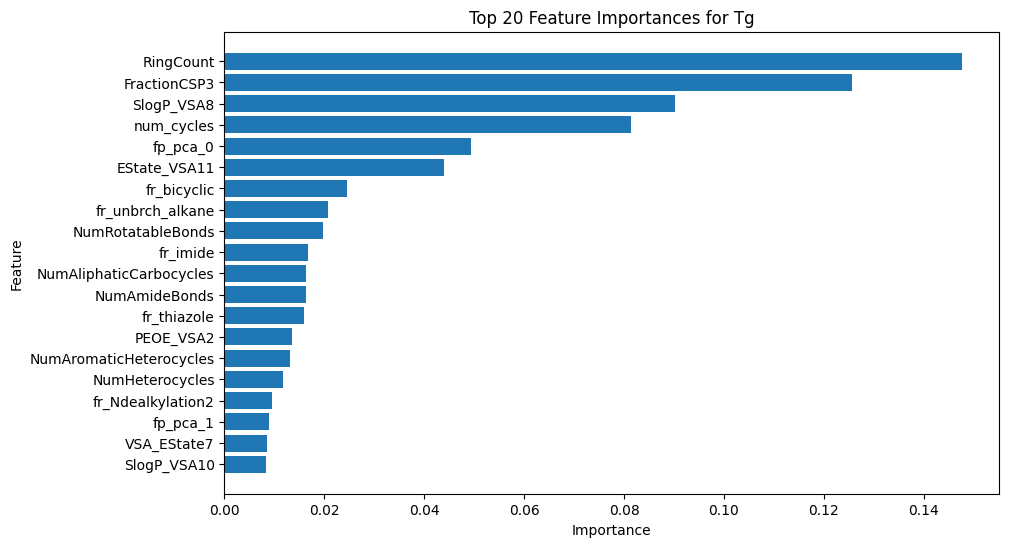

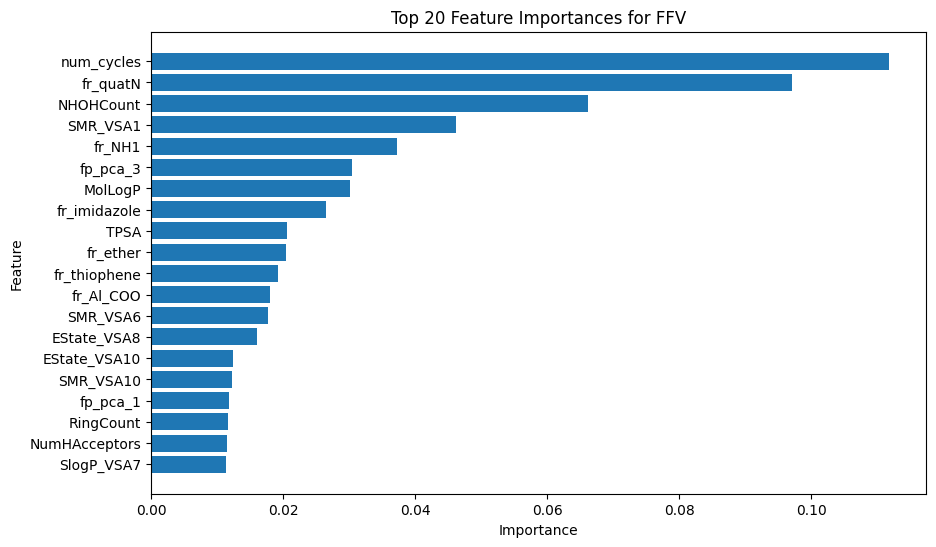

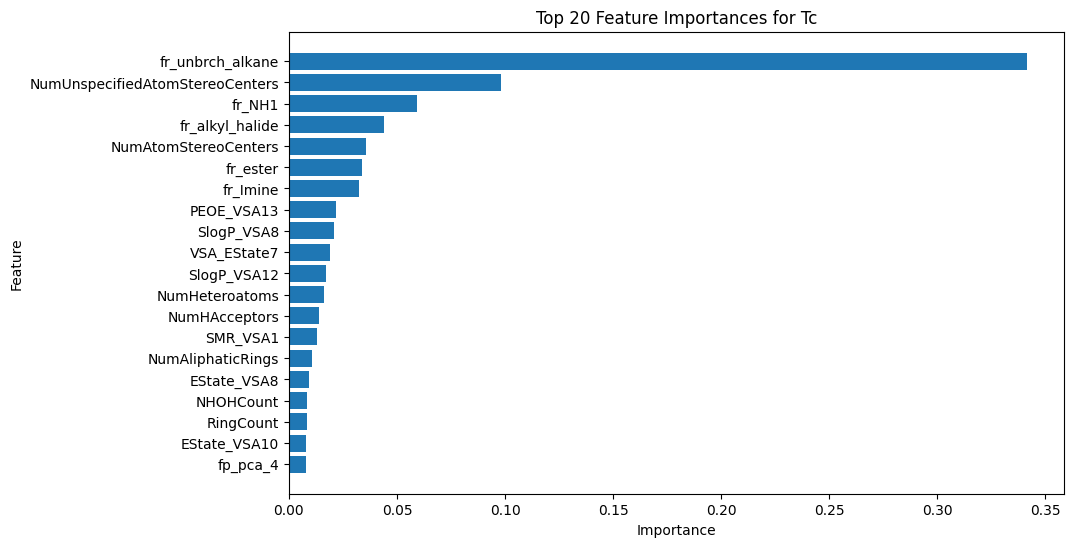

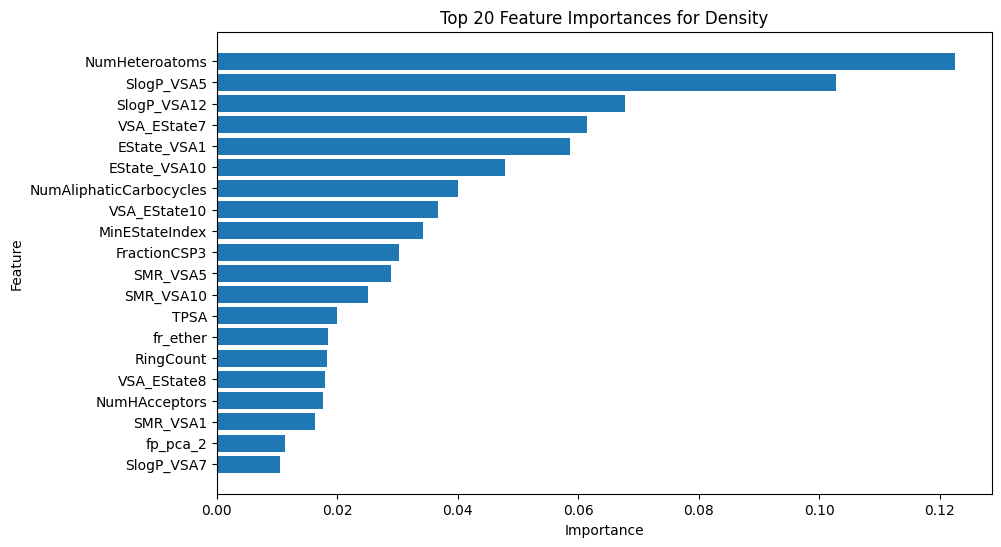

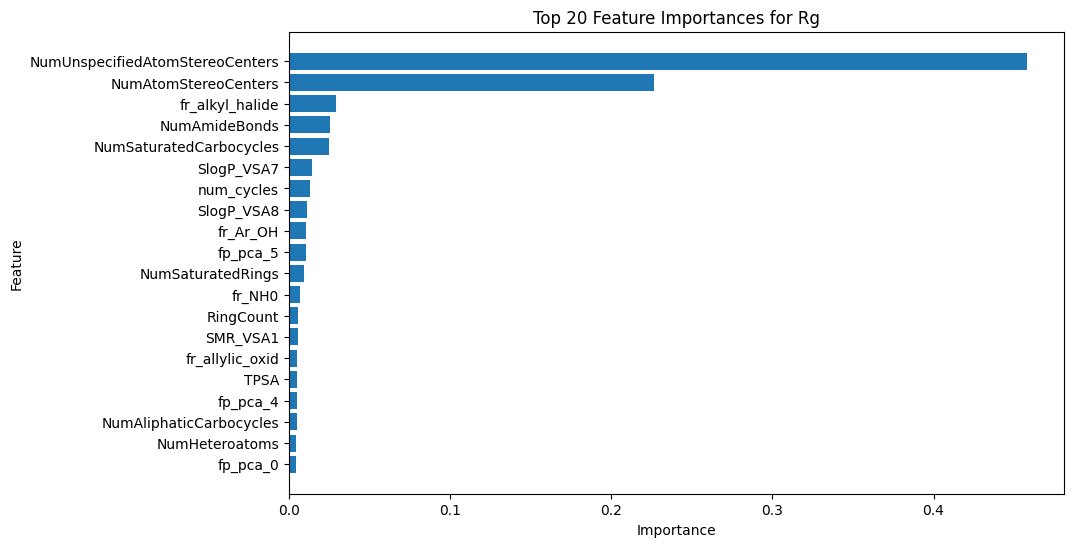

In [26]:
top_n = 20
for target, importances_dict in feature_importances.items():
    # Convert dict to sorted arrays
    features = np.array(list(importances_dict.keys()))
    importances = np.array(list(importances_dict.values()))

    sorted_idx = np.argsort(importances)
    sorted_features = features[sorted_idx][-top_n:]
    sorted_importances = importances[sorted_idx][-top_n:]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importances)
    plt.title(f"Top {top_n} Feature Importances for {target}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

In [48]:
targets

['Tg', 'FFV', 'Tc', 'Density', 'Rg']

In [49]:
pd.DataFrame(feature_importances['Density'], index = [0]).T.sort_values(by = 0, ascending = False).index.tolist()[:26]

['NumHeteroatoms',
 'SlogP_VSA5',
 'SlogP_VSA12',
 'VSA_EState7',
 'EState_VSA1',
 'EState_VSA10',
 'NumAliphaticCarbocycles',
 'VSA_EState10',
 'MinEStateIndex',
 'FractionCSP3',
 'SMR_VSA5',
 'SMR_VSA10',
 'TPSA',
 'fr_ether',
 'RingCount',
 'VSA_EState8',
 'NumHAcceptors',
 'SMR_VSA1',
 'fp_pca_2',
 'SlogP_VSA7',
 'SMR_VSA7',
 'NumAromaticHeterocycles',
 'NumSaturatedCarbocycles',
 'EState_VSA9',
 'VSA_EState9',
 'fr_alkyl_halide']

In [ ]:
cv_results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for target in targets:
    # Drop rows where target is NaN
    df_target = train.dropna(subset=[target])

    c = pd.DataFrame(feature_importances[target], index = [0]).T.sort_values(by = 0, ascending = False).index.tolist()[:40]

    X = df_target[c]
    y = df_target[target]

    # Define the XGBoost model
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist",    # fast histogram-based algorithm
        eval_metric="rmse",
        n_jobs=-1
    )

    # MSE scorer (negative for sklearn, will convert back later)
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    # Cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)

    # Store positive MSE values
    cv_results[target] = -scores

    # Fit once on the full data to extract feature importances
    model.fit(X, y)
    # feature_importances[target] = dict(
    #     zip(cols_to_fit, model.feature_importances_)
    # )

# Display results
for target, mse_scores in cv_results.items():
    print(f"Target: {target}")
    print(f"  Fold MSEs: {mse_scores}")
    print(f"  Mean MSE: {np.mean(mse_scores):.4f}")
    print("-" * 40)



```
Target: Tg
  Fold MSEs: [4250.42876889 5358.35649399 4830.4400398  4255.31657638 4727.1999087 ]
  Mean MSE: 4684.3484
----------------------------------------
Target: FFV
  Fold MSEs: [0.00010047 0.00011067 0.00013465 0.00011089 0.00020256]
  Mean MSE: 0.0001
----------------------------------------
Target: Tc
  Fold MSEs: [0.00243961 0.00100444 0.00194625 0.00189974 0.00173759]
  Mean MSE: 0.0018
----------------------------------------
Target: Density
  Fold MSEs: [0.00438592 0.00619494 0.00294745 0.00240554 0.00318095]
  Mean MSE: 0.0038
----------------------------------------
Target: Rg
  Fold MSEs: [6.20492219 5.65005638 7.35575148 8.91792084 9.28652813]
  Mean MSE: 7.4830
----------------------------------------
```



In [ ]:
best_feats = {
    "Tg": {
        'colsample_bytree': 0.8005575058716043,
        'gamma': 0.7080725777960455,
        'learning_rate': 0.016175348288740735,
        'max_depth': 4,
        'n_estimators': 543,
        'reg_alpha': 1.6648852816008435,
        'reg_lambda': 0.4246782213565523,
        'subsample': 0.5909124836035503
    },
    "FFV": {
        'colsample_bytree': 0.8238450602706812,
        'gamma': 0.0005203769953158188,
        'learning_rate': 0.11577065690025069,
        'max_depth': 5,
        'n_estimators': 558,
        'reg_alpha': 0.32931170628588347,
        'reg_lambda': 1.068178838750884,
        'subsample': 0.7424149856794916
    },
    "Tc": {
        'colsample_bytree': 0.8238450602706812,
        'gamma': 0.0005203769953158188,
        'learning_rate': 0.11577065690025069,
        'max_depth': 5,
        'n_estimators': 558,
        'reg_alpha': 0.32931170628588347,
        'reg_lambda': 1.068178838750884,
        'subsample': 0.7424149856794916
    },
    "Density":['NumHeteroatoms',
 'SlogP_VSA5',
 'SlogP_VSA12',
 'VSA_EState7',
 'EState_VSA1',
 'EState_VSA10',
 'NumAliphaticCarbocycles',
 'VSA_EState10',
 'MinEStateIndex',
 'FractionCSP3',
 'SMR_VSA5',
 'SMR_VSA10',
 'TPSA',
 'fr_ether',
 'RingCount',
 'VSA_EState8',
 'NumHAcceptors',
 'SMR_VSA1',
 'fp_pca_2',
 'SlogP_VSA7',
 'SMR_VSA7',
 'NumAromaticHeterocycles',
 'NumSaturatedCarbocycles',
 'EState_VSA9',
 'VSA_EState9',
 'fr_alkyl_halide'],
    "Rg": ['NumUnspecifiedAtomStereoCenters',
 'NumAtomStereoCenters',
 'fr_alkyl_halide',
 'NumAmideBonds',
 'NumSaturatedCarbocycles',
 'SlogP_VSA7',
 'num_cycles',
 'SlogP_VSA8',
 'fr_Ar_OH',
 'fp_pca_5',
 'NumSaturatedRings',
 'fr_NH0',
 'RingCount',
 'SMR_VSA1',
 'fr_allylic_oxid',
 'TPSA',
 'fp_pca_4',
 'NumAliphaticCarbocycles',
 'NumHeteroatoms',
 'fp_pca_0']
}

##### Hyp Tune

In [ ]:
param_dist = {
    "n_estimators": randint(200, 800),
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.5, 0.5),          # range 0.5–1.0
    "colsample_bytree": uniform(0.5, 0.5),   # range 0.5–1.0
    "gamma": uniform(0.0, 1.0),
    "reg_alpha": uniform(0.0, 2.0),
    "reg_lambda": uniform(0.0, 2.0)
}

best_params = {}
cv_results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

for target in targets:
    # Drop rows with NaN in this target
    df_target = train.dropna(subset=[target])
    X = df_target[cols_to_fit]
    y = df_target[target]

    model = XGBRegressor(
        random_state=42,
        tree_method="hist",
        eval_metric="rmse",
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=30,              # try 30 random combos
        scoring=mse_scorer,
        cv=kf,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X, y)

    best_params[target] = search.best_params_
    cv_results[target] = -search.best_score_  # back to positive MSE

# Display results
for target in targets:
    print(f"Target: {target}")
    print(f"  Best Params: {best_params[target]}")
    print(f"  Best Mean MSE (CV): {cv_results[target]:.4f}")
    print("-" * 40)

Target: Tg
  Best Params: {'colsample_bytree': np.float64(0.8005575058716043), 'gamma': np.float64(0.7080725777960455), 'learning_rate': np.float64(0.016175348288740735), 'max_depth': 4, 'n_estimators': 543, 'reg_alpha': np.float64(1.6648852816008435), 'reg_lambda': np.float64(0.4246782213565523), 'subsample': np.float64(0.5909124836035503)}
  Best Mean MSE (CV): 4362.3438
----------------------------------------
Target: FFV
  Best Params: {'colsample_bytree': np.float64(0.8238450602706812), 'gamma': np.float64(0.0005203769953158188), 'learning_rate': np.float64(0.11577065690025069), 'max_depth': 5, 'n_estimators': 558, 'reg_alpha': np.float64(0.32931170628588347), 'reg_lambda': np.float64(1.068178838750884), 'subsample': np.float64(0.7424149856794916)}
  Best Mean MSE (CV): 0.0002
----------------------------------------
Target: Tc
  Best Params: {'colsample_bytree': np.float64(0.8238450602706812), 'gamma': np.float64(0.0005203769953158188), 'learning_rate': np.float64(0.1157706569002

## Graph NN

In [ ]:
targets = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

In [ ]:
from torch_molecule import GREAMolecularPredictor, GNNMolecularPredictor
from torch_molecule.utils.search import ParameterType, ParameterSpec

# Define search parameters
search_GNN = {
    "gnn_type": ParameterSpec(ParameterType.CATEGORICAL, ["gin-virtual", "gcn-virtual", "gin", "gcn"]),
    "norm_layer": ParameterSpec(ParameterType.CATEGORICAL, ["batch_norm", "layer_norm"]),
    "graph_pooling": ParameterSpec(ParameterType.CATEGORICAL, ["mean", "sum", "max"]),
    "augmented_feature": ParameterSpec(ParameterType.CATEGORICAL, ["maccs,morgan", "maccs", "morgan", None]),
    "num_layer": ParameterSpec(ParameterType.INTEGER, (2, 5)),
    "hidden_size": ParameterSpec(ParameterType.INTEGER, (64, 512)),
    "drop_ratio": ParameterSpec(ParameterType.FLOAT, (0.0, 0.5)),
    "learning_rate": ParameterSpec(ParameterType.LOG_FLOAT, (1e-5, 1e-2)),
    "weight_decay": ParameterSpec(ParameterType.LOG_FLOAT, (1e-10, 1e-3)),
}

search_GREA = {
    "gamma": ParameterSpec(ParameterType.FLOAT, (0.25, 0.75)),
    **search_GNN
}

# Train GREA model
# grea_model = GREAMolecularPredictor(
#     num_task=1,
#     task_type="regression",
#     model_name="GREA_multitask",
#     batch_size=8,
#     epochs=10,
#     evaluate_criterion='mse',
#     evaluate_higher_better=False,
#     verbose=False
# )

In [ ]:
t = ['C1=CC=CC=C1', 'C1=CC=CC=C1']#[[0.5], [1.5]]
np.array(t).shape


(2,)

In [ ]:
np.array(X_train).shape

(6313,)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
N_TRIALS = 5

# Dictionary to store trained models
best_models = {}

for target in [targets[1]]:
    print(f"\n=== Training for target: {target} ===")
    df_target = train.dropna(subset=[target])  # drop rows where this target is missing

    smiles = df_target["SMILES"].tolist()
    y = df_target[target].values.reshape(-1, 1)

    fold_models = []
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(smiles), start=1):
        X_train = [smiles[i] for i in train_idx]
        y_train = y[train_idx].tolist()
        X_val = [smiles[i] for i in val_idx]
        y_val = y[val_idx].tolist()

        model = GREAMolecularPredictor(
            num_task=1,
            task_type="regression",
            model_name=f"GREA_{target}_fold{fold}",
            batch_size=128,
            epochs=10,
            evaluate_criterion='mse',
            evaluate_higher_better=False,
            verbose=False
        )

        model.autofit(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            n_trials=N_TRIALS,
            search_parameters=search_GREA
        )

        # Save trained fold model
        # model_path = f"{target}_fold{fold}.pt"
        # model.save_to_local(model_path)
        # fold_models.append(model_path)

        # Evaluate on validation set
        preds = model.predict(X_val)
        mse = ((preds - y[val_idx]) ** 2).mean()
        fold_scores.append(mse)
        print(f"Fold {fold} MSE: {mse:.4f}")

    best_models[target] = {
        "fold_models": fold_models,
        "mean_mse": sum(fold_scores) / len(fold_scores)
    }

print("\nTraining complete!")
print(best_models)


=== Training for target: FFV ===


TypeError: unsupported operand type(s) for -: 'dict' and 'float'

## Save to Github

In [ ]:
!git config --global user.email "abishpius@gmail.com"
!git config --global user.name "Abish Pius"

In [ ]:
from google.colab import userdata
import requests

token = userdata.get('github')
repo_name = "NeuralIPS-Open-Polymer"
username = "abishpius"
message = "feature optimiz"
notebook_name = "Kaggle_NerualIPS_Open_Polymer.ipynb"

headers = {
    "Authorization": f"token {token}",
    "Accept": "application/vnd.github+json"
}

# === CHECK IF REPO EXISTS ===
check_url = f"https://api.github.com/repos/{username}/{repo_name}"
check_resp = requests.get(check_url, headers=headers)

if check_resp.status_code == 200:
    print(f"❌ Repo '{repo_name}' already exists at: https://github.com/{username}/{repo_name}")
else:
    # === CREATE REPO ===
    create_url = "https://api.github.com/user/repos"
    payload = {
        "name": repo_name,
        "auto_init": True,
        "private": False  # change to True if you want a private repo
    }

    create_resp = requests.post(create_url, headers=headers, json=payload)

    if create_resp.status_code == 201:
        print(f"✅ Repo '{repo_name}' created successfully.")

        # === UPDATE README.md ===
        import base64

        update_url = f"https://api.github.com/repos/{username}/{repo_name}/contents/README.md"
        readme_text = ""
        encoded = base64.b64encode(readme_text.encode()).decode()
        update_payload = {
            "message": message,
            "content": encoded,
            "sha": requests.get(update_url, headers=headers).json()["sha"]
        }

        update_resp = requests.put(update_url, headers=headers, json=update_payload)

        if update_resp.status_code == 200 or update_resp.status_code == 201:
            print("✅ README.md updated with custom text.")
        else:
            print("⚠️ Failed to update README.md:", update_resp.json())

    else:
        print("❌ Repo creation failed:", create_resp.json())

❌ Repo 'NeuralIPS-Open-Polymer' already exists at: https://github.com/abishpius/NeuralIPS-Open-Polymer


In [ ]:
!git clone https://{token}@github.com/{username}/{repo_name}.git

# === MOVE NOTEBOOK ===
import shutil
shutil.copy(f"/content/drive/MyDrive/Colab Notebooks/{notebook_name}", f"/content/{repo_name}/{notebook_name}")

# === COMMIT TO REPO ===
%cd {repo_name}
!git add {notebook_name}
!git commit -m "added much more features"
!git push

Cloning into 'NeuralIPS-Open-Polymer'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 15 (delta 2), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 213.51 KiB | 4.11 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/NeuralIPS-Open-Polymer
[main 9ba4584] added much more features
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Kaggle_NerualIPS_Open_Polymer.ipynb (97%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 7.62 KiB | 162.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/abishpius/NeuralIPS-Open-Polymer.git
   9aba939..9ba4584  main -> main
